In [551]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax, Dropout
from tensorflow.keras import optimizers, callbacks


# Loading Data

In [552]:
df = pd.read_excel(r'C:\Users\khasy\OneDrive\Documents\GitHub\Projects\Assignment 1\Cars_Data_full.xlsx')
df

Price  Age     KM    Fuel   HP  MC   Color  Auto    CC  Drs  ...  AC  \
0     21000   26  31463  Petrol  195   0  Silver     0  1800    3  ...   1   
1     20000   23  43612  Petrol  195   0     Red     0  1800    3  ...   1   
2     19650   26  32191  Petrol  195   0     Red     0  1800    3  ...   1   
3     21550   32  23002  Petrol  195   1   Black     0  1800    3  ...   1   
4     22550   33  34133  Petrol  195   1    Grey     0  1800    3  ...   1   
...     ...  ...    ...     ...  ...  ..     ...   ...   ...  ...  ...  ..   
1362   7550   70  20546  Petrol   89   1    Blue     0  1300    3  ...   0   
1363  10895   73  19002  Petrol   89   0    Grey     0  1300    3  ...   0   
1364   8550   72  17018  Petrol   89   0    Blue     0  1300    3  ...   0   
1365   7300   71  16918  Petrol   89   1    Grey     0  1300    3  ...   0   
1366   7000   77      3  Petrol  113   0   Green     0  1600    5  ...   0   

      Comp  CD  Clock  Pwin  PStr  Radio  SpM  M_Rim  Tow_Bar  
0        0   1      1     1     1      0    0      1        0  
1        1   0      1     1     1      0    1      1        0  
2        1   0      1     1     1      0    1      1        0  
3        1   1      1     1     1      0    1      1        0  
4        1   1      1     1     1      0    1      1        0  
...    ...  ..    ...   ...   ...    ...  ...    ...      ...  
1362     0   0      1     1     1      0    1      0        0  
1363     0   0      0     0     1      0    1      0        0  
1364     0   0      0     0     1      0    0      0        0  
1365     0   0      0     0     0      0    0      0        0  
1366     0   0      0     0     1      0    0      0        0  

[1367 rows x 28 columns]

In [3]:
df.info() #Checks the datatypes of the features
#Fuel has only two values: Petrol or Deisel - Can be converted to an integer using Binary encoding
#Color needs to converted to an integer using label encoding

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Price    1367 non-null   int64 
 1   Age      1367 non-null   int64 
 2   KM       1367 non-null   int64 
 3   Fuel     1367 non-null   object
 4   HP       1367 non-null   int64 
 5   MC       1367 non-null   int64 
 6   Color    1367 non-null   object
 7   Auto     1367 non-null   int64 
 8   CC       1367 non-null   int64 
 9   Drs      1367 non-null   int64 
 10  Cyl      1367 non-null   int64 
 11  Grs      1367 non-null   int64 
 12  Wght     1367 non-null   int64 
 13  G_P      1367 non-null   int64 
 14  Mfr_G    1367 non-null   int64 
 15  ABS      1367 non-null   int64 
 16  Abag_1   1367 non-null   int64 
 17  Abag_2   1367 non-null   int64 
 18  AC       1367 non-null   int64 
 19  Comp     1367 non-null   int64 
 20  CD       1367 non-null   int64 
 21  Clock    1367 non-null   int64 
 22  

# Data Preprocessing

## Encoding Categorical Data

In [553]:
#Convert Fuel type to integer using binary encoding
Fuel_dict = {'Petrol': 1,
            'Diesel': 0} #Assign 1 & 0 for petrol and deisel respectively
df['Fuel_type'] = df.Fuel.map(Fuel_dict)

#Convert Color to integer using label encoding
new_lbl = LabelEncoder()
df['Color_code'] = new_lbl.fit_transform(df['Color'])
df_new = df.drop(['Fuel', 'Color'], axis = 1)

## Feature Selection

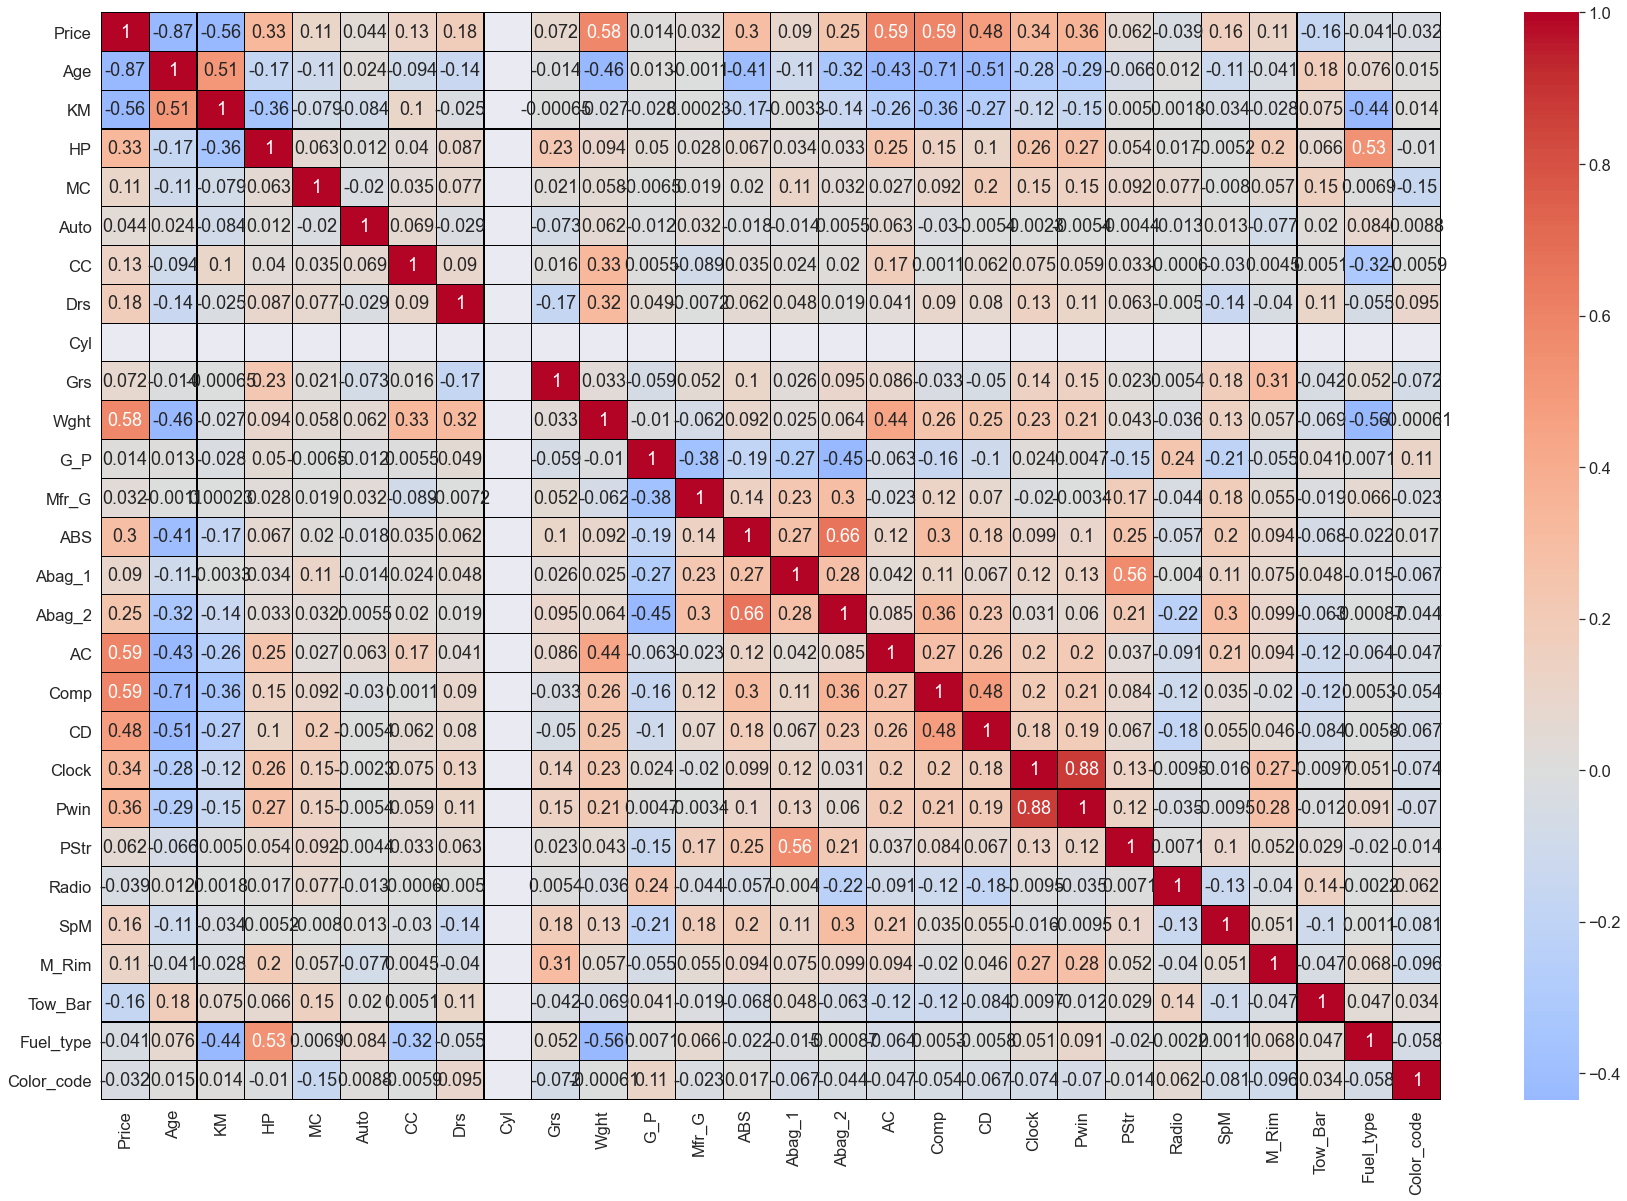

In [554]:
#Check for correlation between the features and the target variable using pearson correlation
correlation = df_new.corr(method='pearson')
#Plot the correlation matrix
plt.figure(figsize=(30,20))
sns.set(font_scale=1.5)
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap='coolwarm', annot=True, 
            linewidths = 0.1, linecolor='black',robust = True, annot_kws={"size": 18}, center= 0)

## Correlation and P-value tests

In [555]:
#Establishing the features and the target parameters
X = df_new.drop(columns=['Price'])
y = df_new.Price

#Combining correlation and p-value test
lin_reg = sm.OLS(y,X).fit()
p = lin_reg.pvalues
p_df = pd.DataFrame(p)
p_df.columns = ['p_value']
correlation_new = correlation['Price'].copy()
correlation_new = correlation_new.drop(['Price'], axis =0)
corr_df = pd.DataFrame(correlation_new)
corr_df.columns = ['Correlation']
features_df = pd.concat([corr_df,p_df], axis = 1)

#Setting criterias for the features based on correlation and p_value
features_df = features_df.loc[(features_df['Correlation'] > 0.2) | (features_df['Correlation'] < -0.2) & (features_df['p_value'] < 0.05) ]
features_df

Correlation        p_value
Age       -0.874000  1.064831e-172
KM        -0.563606   5.150548e-40
HP         0.329473   6.085411e-10
Wght       0.582299   5.629209e-27
ABS        0.296484   6.355176e-04
Abag_2     0.245055   2.150032e-01
AC         0.594625   5.040576e-45
Comp       0.592932   4.575050e-02
CD         0.477470   7.882895e-03
Clock      0.343373   9.999234e-01
Pwin       0.357218   4.090499e-03

In [556]:
#After testing the model without each of the features, the final features to drop keep were KM, Age, Wght, AC, Comp, CD & HP
features_df = features_df.drop(['ABS','Abag_2','Clock','Pwin'], axis=0)
#Final features
df_new = df[['Age','KM','Wght','AC','CD','HP','Comp']]
df_new


Age     KM  Wght  AC  CD   HP  Comp
0      26  31463  1189   1   1  195     0
1      23  43612  1189   1   0  195     1
2      26  32191  1189   1   0  195     1
3      32  23002  1189   1   1  195     1
4      33  34133  1189   1   1  195     1
...   ...    ...   ...  ..  ..  ...   ...
1362   70  20546  1029   0   0   89     0
1363   73  19002  1019   0   0   89     0
1364   72  17018  1019   0   0   89     0
1365   71  16918  1019   0   0   89     0
1366   77      3  1118   0   0  113     0

[1367 rows x 7 columns]

# Linear Regression Model

## Cross-Validation

In [651]:
#Establishing the features and the target parameters
X = df_new
y = df.Price

#Splitting the data into training and testing (80% - Training and 20% - Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
len(X_train.columns)

#Cross-Validation grid serach
folds = KFold(n_splits = 5, shuffle = True, random_state = 42) #K value of 5 selected based on literature as it doesn't suffer from high variance or high bias. 
hyper_params = [{'n_features_to_select': list(range(1,8))}] #Range selected based on the number of features
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm) #Recursive Feature Elimination used as the estimator
model_cv = GridSearchCV(estimator = rfe,
                       param_grid = hyper_params,
                       scoring = 'r2',
                       cv = folds,
                       verbose = 1,
                       return_train_score = False)
model_cv.fit(X_train, y_train)

cv_result = pd.DataFrame(model_cv.cv_results_)
cv_result

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007985      0.000631         0.002388    4.938711e-04   
1       0.005991      0.000026         0.001989    1.300813e-05   
2       0.006186      0.000381         0.001793    3.978683e-04   
3       0.005392      0.000483         0.001995    2.431402e-07   
4       0.005777      0.000745         0.002388    4.940563e-04   
5       0.004389      0.000488         0.001994    1.016010e-06   
6       0.003198      0.000412         0.001989    1.272324e-05   

  param_n_features_to_select                       params  split0_test_score  \
0                          1  {'n_features_to_select': 1}           0.380740   
1                          2  {'n_features_to_select': 2}           0.616567   
2                          3  {'n_features_to_select': 3}           0.653001   
3                          4  {'n_features_to_select': 4}           0.805056   
4                          5  {'n_features_to_select': 5}           0.828182   
5                          6  {'n_features_to_select': 6}           0.826649   
6                          7  {'n_features_to_select': 7}           0.851847   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.410369           0.355428           0.361558           0.255086   
1           0.536868           0.573184           0.540921           0.476621   
2           0.571955           0.601838           0.550574           0.502427   
3           0.843363           0.861028           0.818776           0.788259   
4           0.852352           0.872981           0.834069           0.817383   
5           0.876772           0.877384           0.870361           0.853308   
6           0.893791           0.897015           0.891074           0.864506   

   mean_test_score  std_test_score  rank_test_score  
0         0.352636        0.052395                7  
1         0.548832        0.046046                6  
2         0.575959        0.050344                5  
3         0.823296        0.026104                4  
4         0.840993        0.019605                3  
5         0.860895        0.019204                2  
6         0.879646        0.018080                1

## Model Performance

In [652]:
#Based on the features selected, the grid search shows the the best result can be attained with all 7 features

#Establish linear regression model 
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)

#Predict based on the linear regression model & metrics
pred = lin_reg_mod.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
test_set_r2 = r2_score(y_test, pred)*100

print('The R^2 score is', test_set_r2)
print('The RMSE is', test_set_rmse)

The R^2 score is 84.79109477795046
The RMSE is 1274.6474064167055


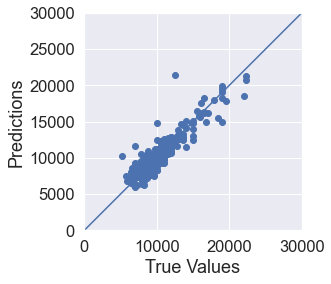

In [644]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 30000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


# Neural Network Model

## Final Model

In [656]:
tf.random.set_seed(500)

#Normalize the features 
x = df_new.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_df = pd.DataFrame(x_scaled)

X_2 = X_df
y_2 = df.Price

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state = 42)

#Neural Network Model
model = Sequential()

#Input Layer
model.add(Dense(units = 7, activation= 'relu', input_dim = X_2.shape[1]))

#Hidden Layers
model.add(Dense(units = 13, activation='relu')) 

model.add(Dense(units = 13, activation='relu')) 

model.add(Dense(units = 13, activation='relu'))

# model.add(Dense(units = 13, activation='relu'))


#Output Layer
model.add(Dense(units = 1, activation = 'relu'))
 
    
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#Early stop factors to avoid overfitting: Learning rate set at 3% & loss delta set to 0
early_stopping = callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=8, min_lr=0.03, verbose=1)


#Intial estimate of 500 epochs, with added early stopping and Validation data taken as 30% of the training data
history = model.fit(X_train_2, y_train_2, epochs = 500, validation_split = 0.3, batch_size = 32, callbacks= [early_stopping, reduce_lr])


Epoch 1/500
24/24 [==============================] - 0s 8ms/step - loss: 130100464.0000 - mse: 130100464.0000 - val_loss: 124115896.0000 - val_mse: 124115896.0000
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 130094744.0000 - mse: 130094744.0000 - val_loss: 124107592.0000 - val_mse: 124107592.0000
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 130082600.0000 - mse: 130082600.0000 - val_loss: 124090120.0000 - val_mse: 124090120.0000
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 130056168.0000 - mse: 130056168.0000 - val_loss: 124051016.0000 - val_mse: 124051016.0000
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 129994704.0000 - mse: 129994704.0000 - val_loss: 123960472.0000 - val_mse: 123960472.0000
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 129856480.0000 - mse: 129856480.0000 - val_loss: 123761056.0000 - val_mse: 123761056.0000
Epoch 7/500
24/24 [===

Epoch 53/500
24/24 [==============================] - 0s 2ms/step - loss: 7213048.5000 - mse: 7213048.5000 - val_loss: 6773848.0000 - val_mse: 6773848.0000
Epoch 54/500
24/24 [==============================] - 0s 2ms/step - loss: 7148059.0000 - mse: 7148059.0000 - val_loss: 6741913.0000 - val_mse: 6741913.0000
Epoch 55/500
24/24 [==============================] - 0s 2ms/step - loss: 7090357.5000 - mse: 7090357.5000 - val_loss: 6692191.0000 - val_mse: 6692191.0000
Epoch 56/500
24/24 [==============================] - 0s 2ms/step - loss: 7032017.0000 - mse: 7032017.0000 - val_loss: 6641892.0000 - val_mse: 6641892.0000
Epoch 57/500
24/24 [==============================] - 0s 2ms/step - loss: 6977696.5000 - mse: 6977696.5000 - val_loss: 6603153.0000 - val_mse: 6603153.0000
Epoch 58/500
24/24 [==============================] - 0s 2ms/step - loss: 6921295.0000 - mse: 6921295.0000 - val_loss: 6544750.0000 - val_mse: 6544750.0000
Epoch 59/500
24/24 [==============================] - 0s 2ms/ste

24/24 [==============================] - 0s 2ms/step - loss: 4789493.5000 - mse: 4789493.5000 - val_loss: 4649969.0000 - val_mse: 4649969.0000
Epoch 106/500
24/24 [==============================] - 0s 2ms/step - loss: 4734612.5000 - mse: 4734612.5000 - val_loss: 4608470.0000 - val_mse: 4608470.0000
Epoch 107/500
24/24 [==============================] - 0s 2ms/step - loss: 4700403.5000 - mse: 4700403.5000 - val_loss: 4574747.5000 - val_mse: 4574747.5000
Epoch 108/500
24/24 [==============================] - 0s 2ms/step - loss: 4653110.0000 - mse: 4653110.0000 - val_loss: 4529762.5000 - val_mse: 4529762.5000
Epoch 109/500
24/24 [==============================] - 0s 2ms/step - loss: 4621706.0000 - mse: 4621706.0000 - val_loss: 4502532.0000 - val_mse: 4502532.0000
Epoch 110/500
24/24 [==============================] - 0s 2ms/step - loss: 4590904.5000 - mse: 4590904.5000 - val_loss: 4453316.5000 - val_mse: 4453316.5000
Epoch 111/500
24/24 [==============================] - 0s 2ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 2883962.7500 - mse: 2883962.7500 - val_loss: 2822023.0000 - val_mse: 2822023.0000
Epoch 158/500
24/24 [==============================] - 0s 2ms/step - loss: 2859063.0000 - mse: 2859063.0000 - val_loss: 2793405.5000 - val_mse: 2793405.5000
Epoch 159/500
24/24 [==============================] - 0s 2ms/step - loss: 2823687.0000 - mse: 2823687.0000 - val_loss: 2764533.2500 - val_mse: 2764533.2500
Epoch 160/500
24/24 [==============================] - 0s 2ms/step - loss: 2795759.5000 - mse: 2795759.5000 - val_loss: 2735107.5000 - val_mse: 2735107.5000
Epoch 161/500
24/24 [==============================] - 0s 2ms/step - loss: 2769971.7500 - mse: 2769971.7500 - val_loss: 2700892.0000 - val_mse: 2700892.0000
Epoch 162/500
24/24 [==============================] - 0s 2ms/step - loss: 2737901.0000 - mse: 2737901.0000 - val_loss: 2672589.0000 - val_mse: 2672589.0000
Epoch 163/500
24/24 [==============================] - 0s 2ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 1858637.1250 - mse: 1858637.1250 - val_loss: 1740662.5000 - val_mse: 1740662.5000
Epoch 210/500
24/24 [==============================] - 0s 2ms/step - loss: 1848200.5000 - mse: 1848200.5000 - val_loss: 1730625.7500 - val_mse: 1730625.7500
Epoch 211/500
24/24 [==============================] - 0s 2ms/step - loss: 1838573.8750 - mse: 1838573.8750 - val_loss: 1720436.6250 - val_mse: 1720436.6250
Epoch 212/500
24/24 [==============================] - 0s 2ms/step - loss: 1833337.1250 - mse: 1833337.1250 - val_loss: 1711855.2500 - val_mse: 1711855.2500
Epoch 213/500
24/24 [==============================] - 0s 2ms/step - loss: 1825499.7500 - mse: 1825499.7500 - val_loss: 1703264.6250 - val_mse: 1703264.6250
Epoch 214/500
24/24 [==============================] - 0s 2ms/step - loss: 1811779.8750 - mse: 1811779.8750 - val_loss: 1692318.6250 - val_mse: 1692318.6250
Epoch 215/500
24/24 [==============================] - 0s 2ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 1579610.3750 - mse: 1579610.3750 - val_loss: 1418118.8750 - val_mse: 1418118.8750
Epoch 262/500
24/24 [==============================] - 0s 2ms/step - loss: 1572109.0000 - mse: 1572109.0000 - val_loss: 1414853.1250 - val_mse: 1414853.1250
Epoch 263/500
24/24 [==============================] - 0s 2ms/step - loss: 1569214.6250 - mse: 1569214.6250 - val_loss: 1409744.0000 - val_mse: 1409744.0000
Epoch 264/500
24/24 [==============================] - 0s 2ms/step - loss: 1573110.7500 - mse: 1573110.7500 - val_loss: 1407293.5000 - val_mse: 1407293.5000
Epoch 265/500
24/24 [==============================] - 0s 2ms/step - loss: 1564406.2500 - mse: 1564406.2500 - val_loss: 1406864.6250 - val_mse: 1406864.6250
Epoch 266/500
24/24 [==============================] - 0s 2ms/step - loss: 1565013.8750 - mse: 1565013.8750 - val_loss: 1402510.7500 - val_mse: 1402510.7500
Epoch 267/500
24/24 [==============================] - 0s 2ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 1465708.2500 - mse: 1465708.2500 - val_loss: 1297356.3750 - val_mse: 1297356.3750
Epoch 314/500
24/24 [==============================] - 0s 2ms/step - loss: 1466326.8750 - mse: 1466326.8750 - val_loss: 1295502.3750 - val_mse: 1295502.3750
Epoch 315/500
24/24 [==============================] - 0s 2ms/step - loss: 1461967.5000 - mse: 1461967.5000 - val_loss: 1295018.2500 - val_mse: 1295018.2500
Epoch 316/500
24/24 [==============================] - 0s 2ms/step - loss: 1460197.7500 - mse: 1460197.7500 - val_loss: 1293556.1250 - val_mse: 1293556.1250
Epoch 317/500
24/24 [==============================] - 0s 2ms/step - loss: 1459249.8750 - mse: 1459249.8750 - val_loss: 1292422.1250 - val_mse: 1292422.1250
Epoch 318/500
24/24 [==============================] - 0s 2ms/step - loss: 1462375.7500 - mse: 1462375.7500 - val_loss: 1292877.1250 - val_mse: 1292877.1250
Epoch 319/500
24/24 [==============================] - 0s 2ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 1392839.3750 - mse: 1392839.3750 - val_loss: 1219300.6250 - val_mse: 1219300.6250
Epoch 366/500
24/24 [==============================] - 0s 2ms/step - loss: 1389439.6250 - mse: 1389439.6250 - val_loss: 1220970.7500 - val_mse: 1220970.7500
Epoch 367/500
24/24 [==============================] - 0s 2ms/step - loss: 1387739.7500 - mse: 1387739.7500 - val_loss: 1214313.5000 - val_mse: 1214313.5000
Epoch 368/500
24/24 [==============================] - 0s 2ms/step - loss: 1395427.2500 - mse: 1395427.2500 - val_loss: 1228542.5000 - val_mse: 1228542.5000
Epoch 369/500
24/24 [==============================] - 0s 2ms/step - loss: 1386990.8750 - mse: 1386990.8750 - val_loss: 1210650.0000 - val_mse: 1210650.0000
Epoch 370/500
24/24 [==============================] - 0s 2ms/step - loss: 1385160.0000 - mse: 1385160.0000 - val_loss: 1212513.6250 - val_mse: 1212513.6250
Epoch 371/500
24/24 [==============================] - 0s 2ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 1335543.2500 - mse: 1335543.2500 - val_loss: 1162688.6250 - val_mse: 1162688.6250
Epoch 418/500
24/24 [==============================] - 0s 2ms/step - loss: 1328473.8750 - mse: 1328473.8750 - val_loss: 1163935.6250 - val_mse: 1163935.6250
Epoch 419/500
24/24 [==============================] - 0s 2ms/step - loss: 1327363.3750 - mse: 1327363.3750 - val_loss: 1162172.5000 - val_mse: 1162172.5000
Epoch 420/500
24/24 [==============================] - 0s 2ms/step - loss: 1339555.2500 - mse: 1339555.2500 - val_loss: 1172256.0000 - val_mse: 1172256.0000
Epoch 421/500
24/24 [==============================] - 0s 2ms/step - loss: 1330673.7500 - mse: 1330673.7500 - val_loss: 1158751.7500 - val_mse: 1158751.7500
Epoch 422/500
24/24 [==============================] - 0s 2ms/step - loss: 1324830.0000 - mse: 1324830.0000 - val_loss: 1161638.1250 - val_mse: 1161638.1250
Epoch 423/500
24/24 [==============================] - 0s 2ms/step - los

## Error Loss Graph

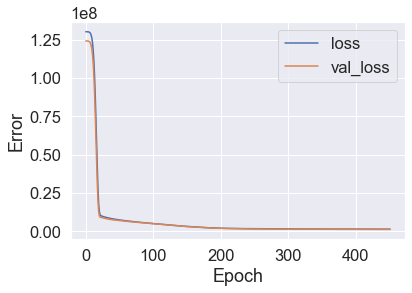

In [642]:
#Plots the error loss for both the loss and the validation loss for each epoch
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Model Performance

In [643]:
#Predict based on the neural network model & metrics
nn_pred = model.predict(X_test_2)
test_nn_r2 = r2_score(y_test_2,nn_pred)*100
test_nn_rmse = (np.sqrt(mean_squared_error(y_test_2, nn_pred)))

print('The R^2 score is', test_nn_r2)
print('The RMSE is', test_nn_rmse)


The R^2 score is 85.38266009125087
The RMSE is 1249.6122182496297


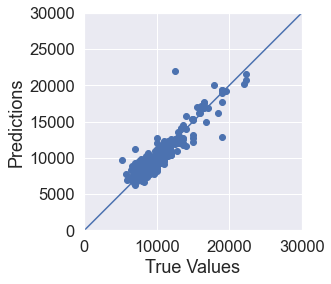

In [653]:
test_predictions = nn_pred.flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test_2, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 30000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)